## Pass and Fail likelihood

In [1]:
## Import libraries
import os
import gzip
import json
import datetime
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import warnings

warnings.filterwarnings("ignore")
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

## Import dataframe

### Test 1

In [2]:
test_id = "28698040" # Pre-commit test

In [3]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [4]:
passing_train.head()

,Unnamed: 0,created_at,updated_at,run_id,status,conclusion,run_duration,test_id
0,12,2022-12-14T15:53:31Z,2022-12-14T15:54:12Z,3696463705,completed,success,41.0,28698040
1,28,2022-06-29T20:52:20Z,2022-06-29T20:52:49Z,2585823572,completed,success,29.0,28698040
2,7,2022-10-25T20:59:24Z,2022-10-25T21:00:05Z,3324245010,completed,success,41.0,28698040
3,6,2022-07-12T21:11:13Z,2022-07-12T21:11:42Z,2659424327,completed,success,29.0,28698040
4,23,2022-07-05T15:28:26Z,2022-07-05T15:29:06Z,2617219129,completed,success,40.0,28698040


In [5]:
failing_train.head()

,Unnamed: 0,created_at,updated_at,run_id,status,conclusion,run_duration,test_id
0,8,2022-10-11T15:27:59Z,2022-10-11T21:30:30Z,3228155174,completed,failure,21751.0,28698040
1,19,2022-09-27T19:49:11Z,2022-09-27T19:49:59Z,3138511295,completed,failure,48.0,28698040
2,0,2022-12-01T18:58:49Z,2022-12-01T18:59:25Z,3595655421,completed,failure,36.0,28698040
3,16,2022-11-16T19:04:40Z,2022-11-16T19:05:09Z,3482315892,completed,failure,29.0,28698040
4,6,2022-12-08T16:33:31Z,2022-12-08T16:33:57Z,3650200301,completed,failure,26.0,28698040


In [6]:
ranges = np.arange(0, max(passing_train['run_duration'])+1, 10).tolist()
ranges.append(np.inf)

In [7]:
# time bucket passing and failing run durations into buckets of 10 seconds
# TODO: find a way to automate the time buckets. Right now 10 seconds/30 seconds seems like 
# a good approximation for more tests

In [8]:
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)

In [9]:
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)

In [10]:
# get frequency of how many tests lie in those time buckets

In [11]:
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())

In [12]:
p_vc

,run_duration_ranges
"(0.0, 10.0]",0
"(10.0, 20.0]",0
"(20.0, 30.0]",35
"(30.0, 40.0]",38
"(40.0, 50.0]",12
"(50.0, 60.0]",6
"(60.0, 70.0]",5
"(70.0, inf]",1


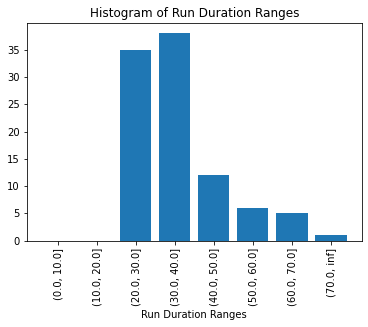

In [13]:
plt.bar(p_vc.index.astype(str), p_vc['run_duration_ranges'].values)

# set the x-axis label and title
plt.xlabel('Run Duration Ranges')
plt.title('Histogram of Run Duration Ranges')
plt.xticks(rotation=90) 

# display the plot
plt.show()

In [14]:
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

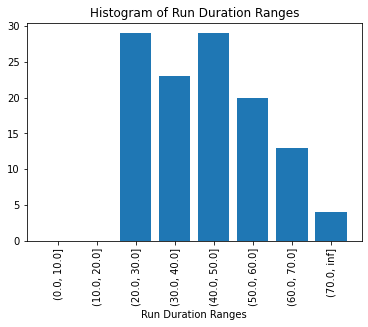

In [15]:
plt.bar(f_vc.index.astype(str), f_vc['run_duration_ranges'].values)

# set the x-axis label and title
plt.xlabel('Run Duration Ranges')
plt.title('Histogram of Run Duration Ranges')
plt.xticks(rotation=90) 

# display the plot
plt.show()

In [16]:
# for start of each time bucket get total number of tests which pass or fail after that point
# get the reverse cumulative sum for that

In [17]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [18]:
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [19]:
p_vc.head()

,run_duration_ranges,prefix_sum
"(0.0, 10.0]",0,97
"(10.0, 20.0]",0,97
"(20.0, 30.0]",35,97
"(30.0, 40.0]",38,62
"(40.0, 50.0]",12,24


In [20]:
f_vc.head()

,run_duration_ranges,prefix_sum
"(0.0, 10.0]",0,118
"(10.0, 20.0]",0,118
"(20.0, 30.0]",29,118
"(30.0, 40.0]",23,89
"(40.0, 50.0]",29,66


In [21]:
max_duration = max(p_vc['prefix_sum'])
p_vc['prefix_sum_percentage'] = p_vc['prefix_sum'] / max_duration * 100
p_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,97,100.000000
"(10.0, 20.0]",0,97,100.000000
"(20.0, 30.0]",35,97,100.000000
"(30.0, 40.0]",38,62,63.917526
"(40.0, 50.0]",12,24,24.742268
"(50.0, 60.0]",6,12,12.371134
"(60.0, 70.0]",5,6,6.185567
"(70.0, inf]",1,1,1.030928


In [22]:
max_duration = max(f_vc['prefix_sum'])
f_vc['prefix_sum_percentage'] = f_vc['prefix_sum'] / max_duration * 100
f_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,118,100.000000
"(10.0, 20.0]",0,118,100.000000
"(20.0, 30.0]",29,118,100.000000
"(30.0, 40.0]",23,89,75.423729
"(40.0, 50.0]",29,66,55.932203
"(50.0, 60.0]",20,37,31.355932
"(60.0, 70.0]",13,17,14.406780
"(70.0, inf]",4,4,3.389831


In [23]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

In [24]:
total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

In [25]:
joined['f_pct']

(0.0, 10.0]     54.883721
(10.0, 20.0]    54.883721
(20.0, 30.0]    54.883721
(30.0, 40.0]    58.940397
(40.0, 50.0]    73.333333
(50.0, 60.0]    75.510204
(60.0, 70.0]    73.913043
(70.0, inf]     80.000000
Name: f_pct, dtype: float64

In [26]:
joined['p_pct']

(0.0, 10.0]     45.116279
(10.0, 20.0]    45.116279
(20.0, 30.0]    45.116279
(30.0, 40.0]    41.059603
(40.0, 50.0]    26.666667
(50.0, 60.0]    24.489796
(60.0, 70.0]    26.086957
(70.0, inf]     20.000000
Name: p_pct, dtype: float64

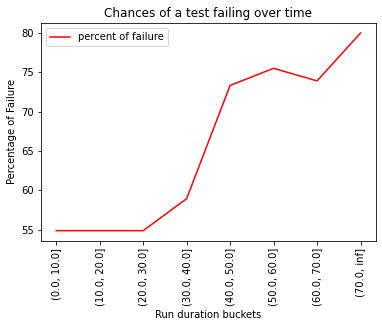

In [27]:
# plot the two series on the same graph
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of Failure')
plt.xticks(rotation=90) 

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

This test was more likely to fail than pass since the start. We see that there could be a point beyond which the test is more than 75% likely to fail.

### Test 2

In [28]:
test_id = "37149896" # File linting

In [29]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [30]:
ranges = np.arange(0, max(passing_train['run_duration'])+1, 10).tolist()
ranges.append(np.inf)

In [31]:
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

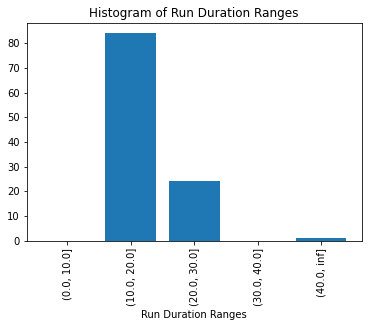

In [32]:
plt.bar(p_vc.index.astype(str), p_vc['run_duration_ranges'].values)

# set the x-axis label and title
plt.xlabel('Run Duration Ranges')
plt.title('Histogram of Run Duration Ranges')
plt.xticks(rotation=90) 

# display the plot
plt.show()

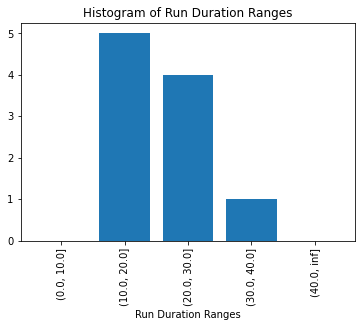

In [33]:
plt.bar(f_vc.index.astype(str), f_vc['run_duration_ranges'].values)

# set the x-axis label and title
plt.xlabel('Run Duration Ranges')
plt.title('Histogram of Run Duration Ranges')
plt.xticks(rotation=90) 

# display the plot
plt.show()

In [34]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [35]:
max_duration = max(p_vc['prefix_sum'])
p_vc['prefix_sum_percentage'] = p_vc['prefix_sum'] / max_duration * 100
p_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,109,100.000000
"(10.0, 20.0]",84,109,100.000000
"(20.0, 30.0]",24,25,22.935780
"(30.0, 40.0]",0,1,0.917431
"(40.0, inf]",1,1,0.917431


In [36]:
max_duration = max(f_vc['prefix_sum'])
f_vc['prefix_sum_percentage'] = f_vc['prefix_sum'] / max_duration * 100
f_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,10,100.0
"(10.0, 20.0]",5,10,100.0
"(20.0, 30.0]",4,5,50.0
"(30.0, 40.0]",1,1,10.0
"(40.0, inf]",0,0,0.0


In [37]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

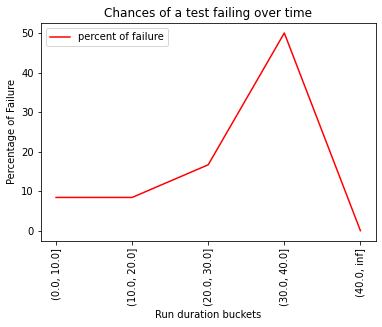

In [38]:
# plot the two series on the same graph
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of Failure')
plt.xticks(rotation=90) 

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

For this test however there is never a point beyond which is it is more than 50% likely to fail. No optimal stopping point exists for this

### Test 3

In [39]:
test_id = "37149895" # Spell Check

In [40]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [41]:
ranges = np.arange(0, max(passing_train['run_duration'])+1, 10).tolist()
ranges.append(np.inf)
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

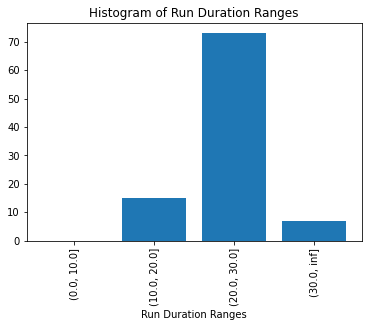

In [42]:
plt.bar(p_vc.index.astype(str), p_vc['run_duration_ranges'].values)

# set the x-axis label and title
plt.xlabel('Run Duration Ranges')
plt.title('Histogram of Run Duration Ranges')
plt.xticks(rotation=90) 

# display the plot
plt.show()

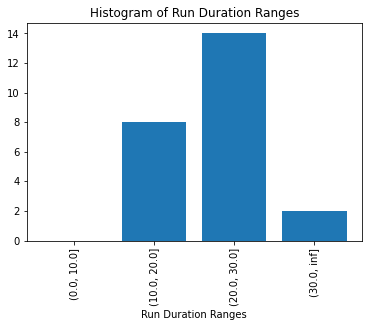

In [43]:
plt.bar(f_vc.index.astype(str), f_vc['run_duration_ranges'].values)

# set the x-axis label and title
plt.xlabel('Run Duration Ranges')
plt.title('Histogram of Run Duration Ranges')
plt.xticks(rotation=90) 

# display the plot
plt.show()

In [44]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [45]:
max_duration = max(p_vc['prefix_sum'])
p_vc['prefix_sum_percentage'] = p_vc['prefix_sum'] / max_duration * 100
p_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,95,100.000000
"(10.0, 20.0]",15,95,100.000000
"(20.0, 30.0]",73,80,84.210526
"(30.0, inf]",7,7,7.368421


In [46]:
max_duration = max(f_vc['prefix_sum'])
f_vc['prefix_sum_percentage'] = f_vc['prefix_sum'] / max_duration * 100
f_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,24,100.000000
"(10.0, 20.0]",8,24,100.000000
"(20.0, 30.0]",14,16,66.666667
"(30.0, inf]",2,2,8.333333


In [47]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

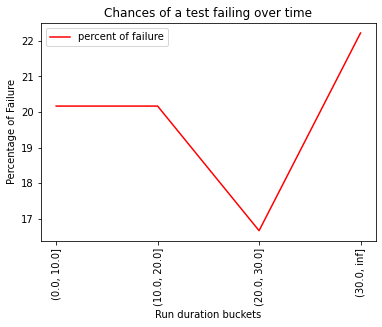

In [48]:
# plot the two series on the same graph
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of Failure')
plt.xticks(rotation=90) 

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

In the above graph we see that the likelihood of a test failing is very low. The above graph is largely impacted by the number of passing and failing tests amongst all tests ie it is impacted by the number of passes and failures.

If we want to ignore the aspect of the number of tests passing and failing and only focus on the trend within the failing tests and the trens within the passing tests, we can normalize the tests. Lets see how that graph looks.

In [49]:
# Scaling does not impact the stopping point hence commenting it out
t_vc = pd.concat([p_vc, f_vc], axis=0)
scaler = MinMaxScaler()
t_vc['run_duration_ranges'] =  scaler.fit_transform(t_vc[['run_duration_ranges']])
rows_split = len(p_vc)  # Number of rows to split on
p_vc = t_vc.head(rows_split)  # First dataframe
f_vc = t_vc.tail(len(t_vc) - rows_split) 

In [50]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [51]:
p_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0.000000,1.30137,100.000000
"(10.0, 20.0]",0.205479,1.30137,100.000000
"(20.0, 30.0]",1.000000,1.09589,84.210526
"(30.0, inf]",0.095890,0.09589,7.368421


In [52]:
f_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0.000000,0.328767,100.000000
"(10.0, 20.0]",0.109589,0.328767,100.000000
"(20.0, 30.0]",0.191781,0.219178,66.666667
"(30.0, inf]",0.027397,0.027397,8.333333


In [53]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

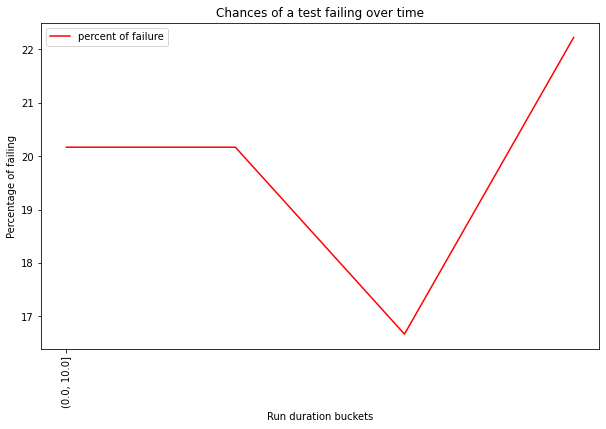

In [54]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

Scaling the passing and failing tests has no impact on the distribution. Hence, we will ignore it

### Test 4: Lets do this for a much larger test dataset

In [55]:
# From the repo https://github.com/github/codeql
test_id = "39411153" #"Compile all queries using the latest stable CodeQL CLI"

In [56]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [57]:
# bucketing into 30 second intervals

ranges = np.arange(0, max(passing_train['run_duration'])+1, 30).tolist()
ranges.append(np.inf)
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

---------------------

#### IQR method to remove outliers

In [58]:
## Mostly thinking of removing this part, just kept it for now if we need to test out the methods after removing outliers

In [59]:
# q1 = passing_train['run_duration'].describe()['25%']
# q3 = passing_train['run_duration'].describe()['75%']
# iqr = q3 - q1
# outlier_threshold = q3 + 6.0 * iqr

In [60]:
# ranges = np.arange(0, int(outlier_threshold)+1, 30).tolist()
# ranges.append(np.inf)
# passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
# failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
# p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
# f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

------------------

In [61]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [62]:
max_duration = max(p_vc['prefix_sum'])
p_vc['prefix_sum_percentage'] = p_vc['prefix_sum'] / max_duration * 100
p_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 30.0]",0,4590,100.000000
"(30.0, 60.0]",0,4590,100.000000
"(60.0, 90.0]",6,4590,100.000000
"(90.0, 120.0]",97,4584,99.869281
"(120.0, 150.0]",591,4487,97.755991
...,...,...,...
"(524460.0, 524490.0]",0,1,0.021786
"(524490.0, 524520.0]",0,1,0.021786
"(524520.0, 524550.0]",0,1,0.021786
"(524550.0, 524580.0]",0,1,0.021786


In [63]:
max_duration = max(f_vc['prefix_sum'])
f_vc['prefix_sum_percentage'] = f_vc['prefix_sum'] / max_duration * 100
f_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 30.0]",7,374,100.000000
"(30.0, 60.0]",32,367,98.128342
"(60.0, 90.0]",72,335,89.572193
"(90.0, 120.0]",53,263,70.320856
"(120.0, 150.0]",56,210,56.149733
...,...,...,...
"(524460.0, 524490.0]",0,2,0.534759
"(524490.0, 524520.0]",0,2,0.534759
"(524520.0, 524550.0]",0,2,0.534759
"(524550.0, 524580.0]",0,2,0.534759


In [64]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

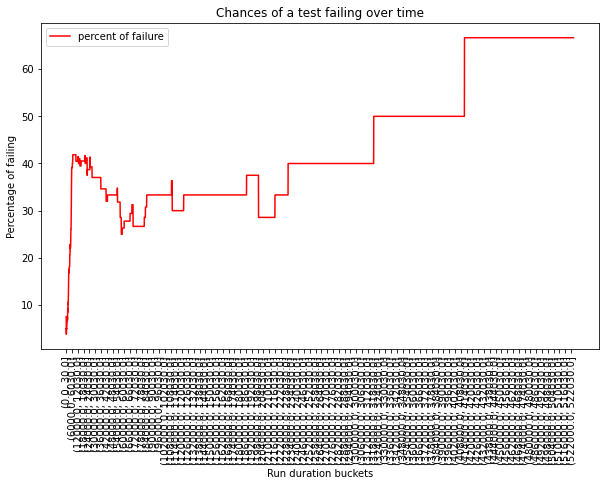

In [65]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

From this graph the chances of a test failing increases over time and we can tell that after a certain time, its roughly 70% likely to fail rather than pass, lets get this turning point programatically

In [66]:
def find_turning_point(s, lower, upper):

    # Find the point at which after which the test is 75% likely to fail 
    # and at all points after then it is never less than 60% likely to fail.
    # Can also parameterize these percentages
    
    sub = pd.Series()
    turning_point = 0
    for index, value in s[::-1].iteritems():
        if value > lower:
            sub.loc[index] = value
        else:
            if sub.empty:
                return 0
            elif not sub.empty:
                turning_point = (sub[::-1] >= upper).idxmax()
                return turning_point

In [67]:
tp = find_turning_point(joined['f_pct'], 60, 75)

In [68]:
tp

Interval(411810.0, 411840.0, closed='right')

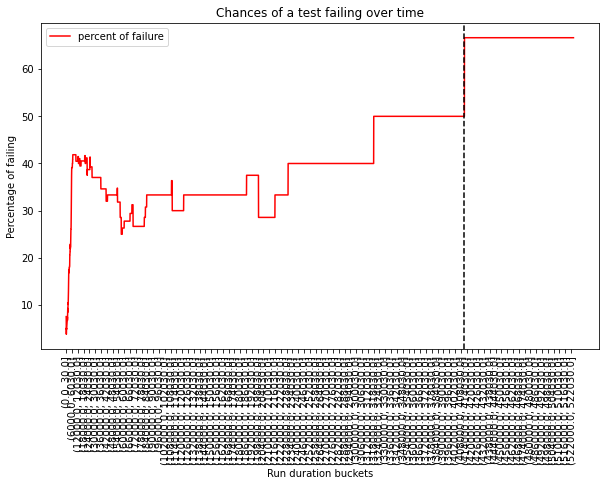

In [69]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()


x_position = joined.index.astype(str).tolist().index(str(tp))
plt.axvline(x=x_position, color='black', linestyle='--')

# show the plot
plt.show()

Let's say we pick 229440.0 as the stopping point beyond which 75 % tests are likely to fail 

Lets evaluate how this does on the test dataset

In [70]:
passing_test = pd.read_csv("../data/processed/{}passing_test.csv".format(test_id))
failing_test = pd.read_csv("../data/processed/{}failing_test.csv".format(test_id))

In [71]:
passing_test.head()

,Unnamed: 0,created_at,updated_at,run_id,status,conclusion,run_duration,test_id
0,29,2023-02-27T12:39:43Z,2023-02-27T12:55:48Z,4282452008,completed,success,965.0,39411153
1,14,2022-11-29T11:54:34Z,2022-11-29T12:01:33Z,3573813896,completed,success,419.0,39411153
2,14,2023-03-24T08:37:26Z,2023-03-24T08:39:43Z,4509293343,completed,success,137.0,39411153
3,10,2022-11-29T09:44:02Z,2022-11-29T10:01:15Z,3572857928,completed,success,1033.0,39411153
4,24,2022-12-14T15:21:31Z,2022-12-14T15:24:19Z,3696199152,completed,success,168.0,39411153


In [72]:
failing_test.head()

,Unnamed: 0,created_at,updated_at,run_id,status,conclusion,run_duration,test_id
0,3,2022-11-04T10:44:16Z,2022-11-04T10:44:42Z,3393142619,completed,failure,26.0,39411153
1,5,2022-11-23T19:38:51Z,2022-11-23T19:42:48Z,3535166257,completed,failure,237.0,39411153
2,15,2023-02-05T13:37:46Z,2023-02-08T19:28:39Z,4096860330,completed,failure,280253.0,39411153
3,16,2023-01-30T15:22:03Z,2023-01-30T15:25:00Z,4045344853,completed,failure,177.0,39411153
4,5,2022-11-04T14:35:32Z,2022-11-04T14:36:09Z,3394648195,completed,failure,37.0,39411153


In [73]:
test_data = pd.concat([passing_test, failing_test], axis=0)

In [74]:
# Add new column with "success" or "failure" based on run_duration
test_data['predicted_status'] = np.where(test_data['run_duration'] > tp.left, 'failure', 'success')

In [75]:
# Calculate percentage of rows where "predicted_status" matches "conclusion"
accuracy = (test_data['predicted_status'] == test_data['conclusion']).sum() / len(test_data) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 92.43%


In [76]:
precision, recall, f1_score, support = precision_recall_fscore_support(test_data['predicted_status'], test_data['conclusion'], average='binary', pos_label='success')

In [77]:
precision

1.0

In [78]:
recall

0.9243156199677939

In [79]:
f1_score

0.9606694560669455

#### Normalize

Above can be impacted by the absolute number of passing and failing tests. Lets normalize the dataset

In [80]:
# From the repo https://github.com/github/codeql
test_id = "39411153" #"Compile all queries using the latest stable CodeQL CLI"

In [81]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [82]:
# bucketing into 30 second intervals

ranges = np.arange(0, max(passing_train['run_duration'])+1, 30).tolist()
ranges.append(np.inf)
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

In [83]:
p_vc

,run_duration_ranges
"(0.0, 30.0]",0
"(30.0, 60.0]",0
"(60.0, 90.0]",6
"(90.0, 120.0]",97
"(120.0, 150.0]",591
...,...
"(524460.0, 524490.0]",0
"(524490.0, 524520.0]",0
"(524520.0, 524550.0]",0
"(524550.0, 524580.0]",0


In [84]:
f_vc

,run_duration_ranges
"(0.0, 30.0]",7
"(30.0, 60.0]",32
"(60.0, 90.0]",72
"(90.0, 120.0]",53
"(120.0, 150.0]",56
...,...
"(524460.0, 524490.0]",0
"(524490.0, 524520.0]",0
"(524520.0, 524550.0]",0
"(524550.0, 524580.0]",0


Here we try to ensure that for each time duration the number of tests is constant, we normalize the dataset to preserve the ratio to passing/failing tests in each bucket but the total number of tests in each bucket is now uniform

In [85]:
combined_vc = pd.concat([p_vc, f_vc], axis=1, keys=['p_', 'f_'])
combined_vc['total'] = combined_vc[('p_', 'run_duration_ranges')] + combined_vc[('f_', 'run_duration_ranges')]
combined_vc[('p_', 'run_duration_ranges')] = combined_vc[('p_', 'run_duration_ranges')]/combined_vc['total']
combined_vc[('f_', 'run_duration_ranges')] = combined_vc[('f_', 'run_duration_ranges')]/combined_vc['total']
combined_vc = combined_vc.fillna(0)
combined_vc

,p_,f_,total
,run_duration_ranges,run_duration_ranges,
"(0.0, 30.0]",0.000000,1.000000,7
"(30.0, 60.0]",0.000000,1.000000,32
"(60.0, 90.0]",0.076923,0.923077,78
"(90.0, 120.0]",0.646667,0.353333,150
"(120.0, 150.0]",0.913447,0.086553,647
...,...,...,...
"(524460.0, 524490.0]",0.000000,0.000000,0
"(524490.0, 524520.0]",0.000000,0.000000,0
"(524520.0, 524550.0]",0.000000,0.000000,0


In [86]:
p_vc = combined_vc['p_']
f_vc = combined_vc['f_']

In [87]:
p_vc

,run_duration_ranges
"(0.0, 30.0]",0.000000
"(30.0, 60.0]",0.000000
"(60.0, 90.0]",0.076923
"(90.0, 120.0]",0.646667
"(120.0, 150.0]",0.913447
...,...
"(524460.0, 524490.0]",0.000000
"(524490.0, 524520.0]",0.000000
"(524520.0, 524550.0]",0.000000
"(524550.0, 524580.0]",0.000000


In [88]:
f_vc

,run_duration_ranges
"(0.0, 30.0]",1.000000
"(30.0, 60.0]",1.000000
"(60.0, 90.0]",0.923077
"(90.0, 120.0]",0.353333
"(120.0, 150.0]",0.086553
...,...
"(524460.0, 524490.0]",0.000000
"(524490.0, 524520.0]",0.000000
"(524520.0, 524550.0]",0.000000
"(524550.0, 524580.0]",0.000000


In [89]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [90]:
p_vc

,run_duration_ranges,prefix_sum
"(0.0, 30.0]",0.000000,148.682307
"(30.0, 60.0]",0.000000,148.682307
"(60.0, 90.0]",0.076923,148.682307
"(90.0, 120.0]",0.646667,148.605384
"(120.0, 150.0]",0.913447,147.958717
...,...,...
"(524460.0, 524490.0]",0.000000,0.333333
"(524490.0, 524520.0]",0.000000,0.333333
"(524520.0, 524550.0]",0.000000,0.333333
"(524550.0, 524580.0]",0.000000,0.333333


In [91]:
f_vc

,run_duration_ranges,prefix_sum
"(0.0, 30.0]",1.000000,25.317693
"(30.0, 60.0]",1.000000,24.317693
"(60.0, 90.0]",0.923077,23.317693
"(90.0, 120.0]",0.353333,22.394616
"(120.0, 150.0]",0.086553,22.041283
...,...,...
"(524460.0, 524490.0]",0.000000,0.666667
"(524490.0, 524520.0]",0.000000,0.666667
"(524520.0, 524550.0]",0.000000,0.666667
"(524550.0, 524580.0]",0.000000,0.666667


In [92]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

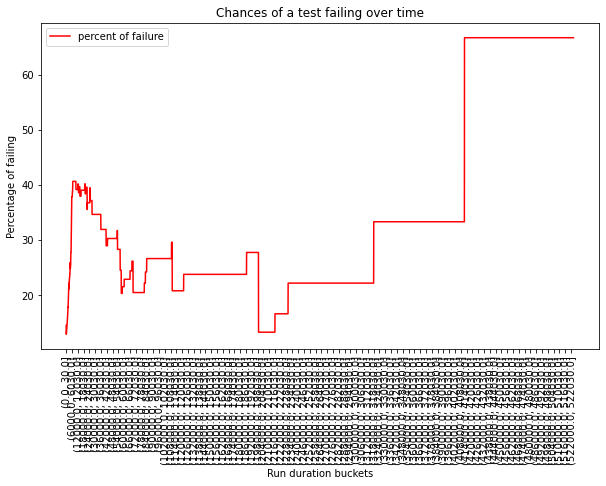

In [93]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

In [94]:
tp = find_turning_point(joined['f_pct'], 60, 75)

In [95]:
tp

Interval(411810.0, 411840.0, closed='right')

In [96]:
test_data = pd.concat([passing_test, failing_test], axis=0)

In [97]:
# Add new column with "success" or "failure" based on run_duration
test_data['predicted_status'] = np.where(test_data['run_duration'] > tp.left, 'failure', 'success')

In [98]:
# Calculate percentage of rows where "predicted_status" matches "conclusion"
accuracy = (test_data['predicted_status'] == test_data['conclusion']).sum() / len(test_data) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 92.43%


In [99]:
precision, recall, f1_score, support = precision_recall_fscore_support(test_data['predicted_status'], test_data['conclusion'], average='binary', pos_label='success')

In [100]:
precision

1.0

In [101]:
recall

0.9243156199677939

In [102]:
f1_score

0.9606694560669455

### Test 5: Another larger test dataset

In [103]:
test_id = "19425791" # "CodeQL tests"

In [104]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [105]:
# bucketing into 30 second intervals

ranges = np.arange(0, max(passing_train['run_duration'])+1, 10).tolist()
ranges.append(np.inf)
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

In [106]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [107]:
max_duration = max(p_vc['prefix_sum'])
p_vc['prefix_sum_percentage'] = p_vc['prefix_sum'] / max_duration * 100
p_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,2623,100.000000
"(10.0, 20.0]",0,2623,100.000000
"(20.0, 30.0]",0,2623,100.000000
"(30.0, 40.0]",0,2623,100.000000
"(40.0, 50.0]",0,2623,100.000000
...,...,...,...
"(4680.0, 4690.0]",0,1,0.038124
"(4690.0, 4700.0]",0,1,0.038124
"(4700.0, 4710.0]",0,1,0.038124
"(4710.0, 4720.0]",1,1,0.038124


In [108]:
max_duration = max(f_vc['prefix_sum'])
f_vc['prefix_sum_percentage'] = f_vc['prefix_sum'] / max_duration * 100
f_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",0,15,100.000000
"(10.0, 20.0]",1,15,100.000000
"(20.0, 30.0]",0,14,93.333333
"(30.0, 40.0]",0,14,93.333333
"(40.0, 50.0]",1,14,93.333333
...,...,...,...
"(4680.0, 4690.0]",0,1,6.666667
"(4690.0, 4700.0]",0,1,6.666667
"(4700.0, 4710.0]",0,1,6.666667
"(4710.0, 4720.0]",0,1,6.666667


In [109]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

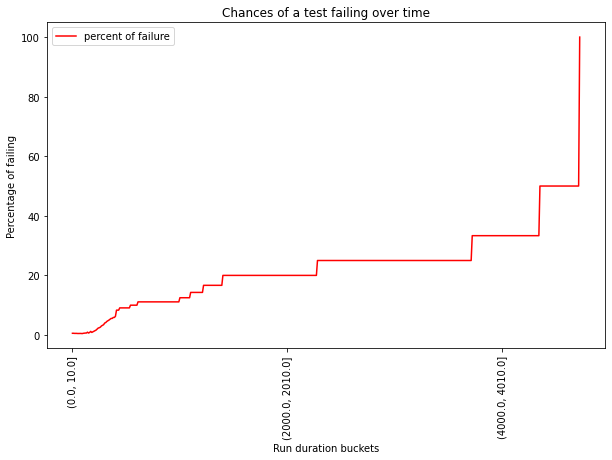

In [110]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

In [111]:
tp = find_turning_point(joined['f_pct'], 60, 75)

In [112]:
tp

Interval(4720.0, inf, closed='right')

In [113]:
passing_test = pd.read_csv("../data/processed/{}passing_test.csv".format(test_id))
failing_test = pd.read_csv("../data/processed/{}failing_test.csv".format(test_id))
test_data = pd.concat([passing_test, failing_test], axis=0)

In [114]:
# Add new column with "success" or "failure" based on run_duration
test_data['predicted_status'] = np.where(test_data['run_duration'] > tp.left, 'failure', 'success')
precision, recall, f1_score, support = precision_recall_fscore_support(test_data['predicted_status'], test_data['conclusion'], average='binary', pos_label='success')

In [115]:
precision

0.9984756097560976

In [116]:
recall

0.9924242424242424

In [117]:
f1_score

0.9954407294832827

#### Normalize

In [118]:
# From the repo https://github.com/github/codeql
test_id = "19425791" # "CodeQL tests"

In [119]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [120]:
# bucketing into 30 second intervals

ranges = np.arange(0, max(passing_train['run_duration'])+1, 30).tolist()
ranges.append(np.inf)
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

In [121]:
combined_vc = pd.concat([p_vc, f_vc], axis=1, keys=['p_', 'f_'])
combined_vc['total'] = combined_vc[('p_', 'run_duration_ranges')] + combined_vc[('f_', 'run_duration_ranges')]
combined_vc[('p_', 'run_duration_ranges')] = combined_vc[('p_', 'run_duration_ranges')]/combined_vc['total']
combined_vc[('f_', 'run_duration_ranges')] = combined_vc[('f_', 'run_duration_ranges')]/combined_vc['total']
combined_vc = combined_vc.fillna(0)
combined_vc

,p_,f_,total
,run_duration_ranges,run_duration_ranges,
"(0.0, 30.0]",0.000000,1.000000,1
"(30.0, 60.0]",0.984375,0.015625,64
"(60.0, 90.0]",0.992481,0.007519,399
"(90.0, 120.0]",0.996797,0.003203,1249
"(120.0, 150.0]",0.993506,0.006494,616
...,...,...,...
"(4590.0, 4620.0]",0.000000,0.000000,0
"(4620.0, 4650.0]",0.000000,0.000000,0
"(4650.0, 4680.0]",0.000000,0.000000,0


In [122]:
p_vc = combined_vc['p_']
f_vc = combined_vc['f_']

In [123]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [124]:
p_vc

,run_duration_ranges,prefix_sum
"(0.0, 30.0]",0.000000,23.461952
"(30.0, 60.0]",0.984375,23.461952
"(60.0, 90.0]",0.992481,22.477577
"(90.0, 120.0]",0.996797,21.485096
"(120.0, 150.0]",0.993506,20.488298
...,...,...
"(4590.0, 4620.0]",0.000000,0.500000
"(4620.0, 4650.0]",0.000000,0.500000
"(4650.0, 4680.0]",0.000000,0.500000
"(4680.0, 4710.0]",0.000000,0.500000


In [125]:
f_vc

,run_duration_ranges,prefix_sum
"(0.0, 30.0]",1.000000,1.538048
"(30.0, 60.0]",0.015625,0.538048
"(60.0, 90.0]",0.007519,0.522423
"(90.0, 120.0]",0.003203,0.514904
"(120.0, 150.0]",0.006494,0.511702
...,...,...
"(4590.0, 4620.0]",0.000000,0.500000
"(4620.0, 4650.0]",0.000000,0.500000
"(4650.0, 4680.0]",0.000000,0.500000
"(4680.0, 4710.0]",0.000000,0.500000


In [126]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

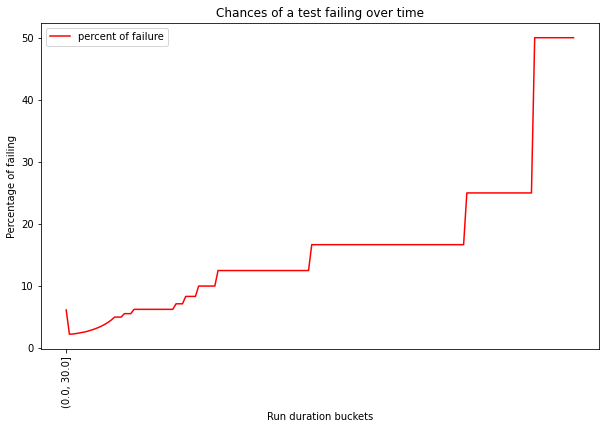

In [127]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

In [128]:
tp = find_turning_point(joined['f_pct'], 60, 75)
tp

0

### Test 6: Another larger test dataset

In [129]:
test_id = "14909022" # "CodeQL tests"

In [130]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [131]:
# bucketing into 30 second intervals

ranges = np.arange(0, max(passing_train['run_duration'])+1, 10).tolist()
ranges.append(np.inf)
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

In [132]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [133]:
max_duration = max(p_vc['prefix_sum'])
p_vc['prefix_sum_percentage'] = p_vc['prefix_sum'] / max_duration * 100
p_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",7,679,100.000000
"(10.0, 20.0]",607,672,98.969072
"(20.0, 30.0]",51,65,9.572901
"(30.0, 40.0]",4,14,2.061856
"(40.0, 50.0]",2,10,1.472754
"(50.0, 60.0]",0,8,1.178203
"(60.0, 70.0]",0,8,1.178203
"(70.0, 80.0]",1,8,1.178203
"(80.0, 90.0]",2,7,1.030928
"(90.0, 100.0]",0,5,0.736377


In [134]:
max_duration = max(f_vc['prefix_sum'])
f_vc['prefix_sum_percentage'] = f_vc['prefix_sum'] / max_duration * 100
f_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",2,38,100.000000
"(10.0, 20.0]",24,36,94.736842
"(20.0, 30.0]",3,12,31.578947
"(30.0, 40.0]",1,9,23.684211
"(40.0, 50.0]",4,8,21.052632
"(50.0, 60.0]",1,4,10.526316
"(60.0, 70.0]",0,3,7.894737
"(70.0, 80.0]",0,3,7.894737
"(80.0, 90.0]",0,3,7.894737
"(90.0, 100.0]",0,3,7.894737


In [135]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

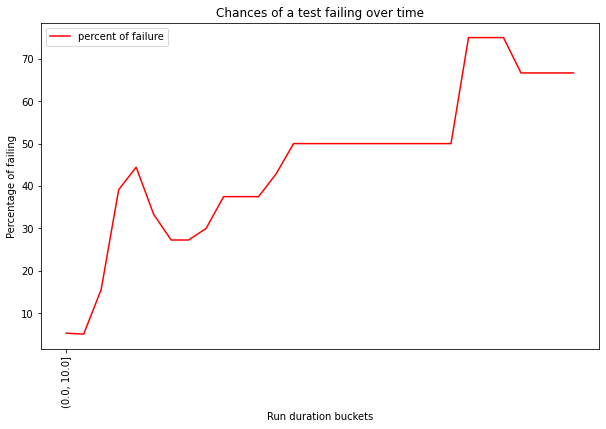

In [136]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

In [137]:
tp = find_turning_point(joined['f_pct'], 60, 75)

In [138]:
tp

Interval(230.0, 240.0, closed='right')

In [139]:
passing_test = pd.read_csv("../data/processed/{}passing_test.csv".format(test_id))
failing_test = pd.read_csv("../data/processed/{}failing_test.csv".format(test_id))

In [140]:
test_data = pd.concat([passing_test, failing_test], axis=0)

In [141]:
# Add new column with "success" or "failure" based on run_duration
test_data['predicted_status'] = np.where(test_data['run_duration'] > tp.left, 'failure', 'success')

In [142]:
precision, recall, f1_score, support = precision_recall_fscore_support(test_data['predicted_status'], test_data['conclusion'], average='binary', pos_label='success')

In [143]:
precision

0.9941176470588236

In [144]:
recall

0.9441340782122905

In [145]:
f1_score

0.9684813753581661

#### Normalize

In [146]:
test_id = "14909022" # "CodeQL tests"

In [147]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [148]:
# bucketing into 30 second intervals

ranges = np.arange(0, max(passing_train['run_duration'])+1, 10).tolist()
ranges.append(np.inf)
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

In [149]:
combined_vc = pd.concat([p_vc, f_vc], axis=1, keys=['p_', 'f_'])
combined_vc['total'] = combined_vc[('p_', 'run_duration_ranges')] + combined_vc[('f_', 'run_duration_ranges')]
combined_vc[('p_', 'run_duration_ranges')] = combined_vc[('p_', 'run_duration_ranges')]/combined_vc['total']
combined_vc[('f_', 'run_duration_ranges')] = combined_vc[('f_', 'run_duration_ranges')]/combined_vc['total']
combined_vc = combined_vc.fillna(0)
combined_vc

,p_,f_,total
,run_duration_ranges,run_duration_ranges,
"(0.0, 10.0]",0.777778,0.222222,9
"(10.0, 20.0]",0.961965,0.038035,631
"(20.0, 30.0]",0.944444,0.055556,54
"(30.0, 40.0]",0.800000,0.200000,5
"(40.0, 50.0]",0.333333,0.666667,6
"(50.0, 60.0]",0.000000,1.000000,1
"(60.0, 70.0]",0.000000,0.000000,0
"(70.0, 80.0]",1.000000,0.000000,1
"(80.0, 90.0]",1.000000,0.000000,2


In [150]:
p_vc = combined_vc['p_']
f_vc = combined_vc['f_']

In [151]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [152]:
p_vc

,run_duration_ranges,prefix_sum
"(0.0, 10.0]",0.777778,9.150854
"(10.0, 20.0]",0.961965,8.373076
"(20.0, 30.0]",0.944444,7.411111
"(30.0, 40.0]",0.800000,6.466667
"(40.0, 50.0]",0.333333,5.666667
"(50.0, 60.0]",0.000000,5.333333
"(60.0, 70.0]",0.000000,5.333333
"(70.0, 80.0]",1.000000,5.333333
"(80.0, 90.0]",1.000000,4.333333
"(90.0, 100.0]",0.000000,3.333333


In [153]:
f_vc

,run_duration_ranges,prefix_sum
"(0.0, 10.0]",0.222222,3.849146
"(10.0, 20.0]",0.038035,3.626924
"(20.0, 30.0]",0.055556,3.588889
"(30.0, 40.0]",0.200000,3.533333
"(40.0, 50.0]",0.666667,3.333333
"(50.0, 60.0]",1.000000,2.666667
"(60.0, 70.0]",0.000000,1.666667
"(70.0, 80.0]",0.000000,1.666667
"(80.0, 90.0]",0.000000,1.666667
"(90.0, 100.0]",0.000000,1.666667


In [154]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

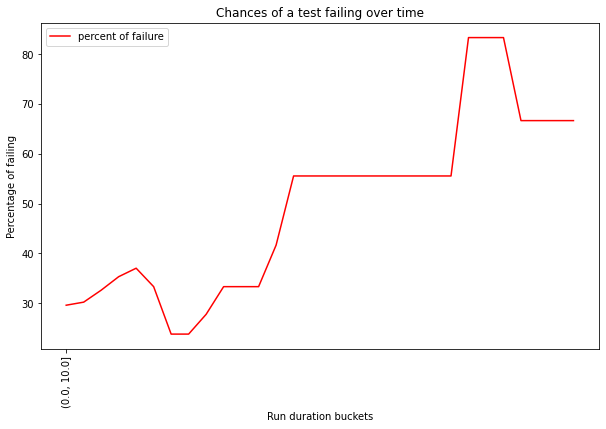

In [155]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

In [156]:
tp = find_turning_point(joined['f_pct'], 60, 75)

In [157]:
tp

Interval(230.0, 240.0, closed='right')

In [158]:
test_data = pd.concat([passing_test, failing_test], axis=0)

In [159]:
# Add new column with "success" or "failure" based on run_duration
test_data['predicted_status'] = np.where(test_data['run_duration'] > tp.left, 'failure', 'success')

In [160]:
precision, recall, f1_score, support = precision_recall_fscore_support(test_data['predicted_status'], test_data['conclusion'], average='binary', pos_label='success')

In [161]:
precision

0.9941176470588236

In [162]:
recall

0.9441340782122905

In [163]:
f1_score

0.9684813753581661

We see that there is no benefit of normalizing the data as the result is either the same or the failure percentage is scaled too low. Hence, for now we will proceed without normalizing or scaling. (We will see below that scaling also does not have an impact on the metrics or the turning point)

#### Scaling

In [164]:
# As we saw earlier, scaling does not impact the stopping point hence commenting it out
t_vc = pd.concat([p_vc, f_vc], axis=0)
scaler = MinMaxScaler()
t_vc['run_duration_ranges'] =  scaler.fit_transform(t_vc[['run_duration_ranges']])
rows_split = len(p_vc)  # Number of rows to split on
p_vc = t_vc.head(rows_split)  # First dataframe
f_vc = t_vc.tail(len(t_vc) - rows_split) 

In [165]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

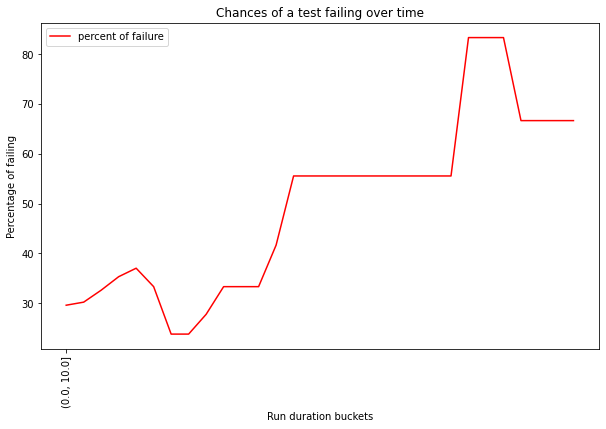

In [166]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

In [167]:
tp = find_turning_point(joined['f_pct'], 60, 75)
tp

Interval(230.0, 240.0, closed='right')

# Conclusion

In this notebook, I evaluated the trends of passing and failing tests and plotted the likelihood of a test to pass or fail throughout the run duration of tests.

For every time interval T, we sum all the successes from T to N (the end if the dataset) divided by the total number of tests in that set. This answers "Given it is now time T, what is the probability that my test will succeed should I allow it to continue" 

Upon normalizing the data, ie. I am scaling the number of tests within each 10 or 30 second time range to be between 0 & 1, we see that though is no impact of normalizing the data on the final result. Hence, for now we will proceed without normalizing or scaling. 

We also saw that for some tests there is no optimal stopping point - meaning it never occurs that a test is more likely to fail than pass.